# Assessment Problems Notebook

## Problem 1 - Extending the Lady Tasting Tea

In this notebook, I will extend the Lady Tasting Tea experiment.

- Original Fisher design: 8 cups total (4 tea-first, 4 milk-first).
- Extended design: 12 cups total (8 tea-first, 4 milk-first).

A participant claims they can tell, for each cup, whether the milk or tea was poured first.  
We want to estimate, by simulation, the probability that a participant with no real ability (i.e. just guessing) correctly identifies all cups in each design.

I will:

1. Simulate the experiment many times using numpy.
2. Estimate the probability of perfectly identifying all cups by chance in:
   - The original 8-cup experiment.
   - The extended 12-cup experiment.
3. Compare the estimated probabilities and discuss what this means for p-values and evidence against the null hypothesis.

In [30]:
# Import Libraries

import math
import itertools
import numpy as np

### Simulation

I randomly assign 4 cups as milk‑first and randomly guess 4 cups.


If the person is just guessing, both choices are random. The proportion of trials where the two sets match is an estimate of the probability of getting all cups correct by chance.

I have decided to run this using 50,000 random trials

In [31]:
# Simulation function
def simulate(n_trials=50000):
    cups = np.arange(12)
    count = 0
    for _ in range(n_trials):
        true_milk = set(np.random.choice(cups,4,replace=False))
        guess = set(np.random.choice(cups,4,replace=False))
        if true_milk == guess:
            count += 1
    return count/n_trials

sim_prob = simulate()
sim_prob

0.00186

Now to compare the 12 cup test with the 8 cup test

In [32]:
exact_prob = 1 / math.comb(12,4)
orig_prob = 1 / math.comb(8,4)
exact_prob, orig_prob

(0.00202020202020202, 0.014285714285714285)

### Interpretation

The 12 cup test makes it much rarer to get a correct guess making this test stronger compared to the 8 cup test.

## Problem 2 - Normal Distribution

In this notebook, I am running a simulation to take a look at the differences between the sample standard deviation (using ddof=1) and the population standard deviation (using ddof=0). To explore this, I’m generating 100,000 random samples from a standard normal distribution, and each sample consists of 10 values. 

For each sample, I calculate both types of standard deviation and then plot them on the same histogram. This allows me to easily compare their behavior. The goal is to see how much the two formulas differ when dealing with smaller sample sizes, and to also consider how that difference might change as the sample size increases.

In [33]:
# Importing Libraries

import numpy as np
import matplotlib.pyplot as plt

In the next cell I am setting the number of samples and creating 100,000 sets of 10 random values from the standard normal distribution. 


In [34]:
# Parameters
n_samples = 100_000   # number of samples
sample_size = 10      # size of each sample

# Generate samples from the standard normal distribution
# Shape: (100000, 10)
samples = np.random.randn(n_samples, sample_size)



Now I calculate the standard deviation for each sample twice: once using ddof=1 (the sample SD) and once using ddof=0 (the population SD). This gives me two separate arrays of SD values.

In [35]:
# Compute standard deviations:
# ddof=1 → sample standard deviation
sd_sample = np.std(samples, axis=1, ddof=1)

# ddof=0 → population standard deviation
sd_population = np.std(samples, axis=1, ddof=0)

Next I plot both sets of standard deviations on the same graph. I use transparency so I can compare the two distributions easily and see how they overlap.

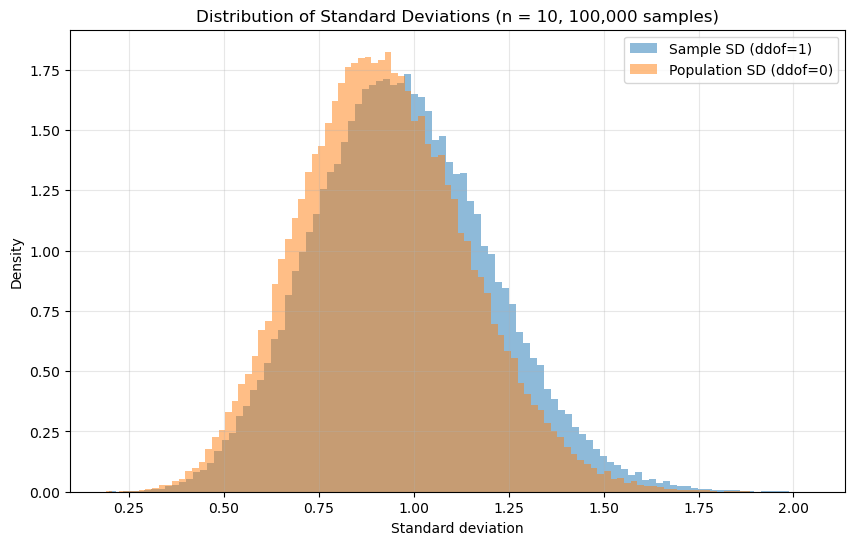

In [36]:
plt.figure(figsize=(10, 6))

# Plot histograms with transparency
plt.hist(sd_sample,
         bins=100,
         alpha=0.5,
         density=True,
         label="Sample SD (ddof=1)")

plt.hist(sd_population,
         bins=100,
         alpha=0.5,
         density=True,
         label="Population SD (ddof=0)")

plt.title("Distribution of Standard Deviations (n = 10, 100,000 samples)")
plt.xlabel("Standard deviation")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


### Understanding the Differences

- When examining the contrasts between the population standard deviation  and the sample standard deviation , it's crucial to focus on their shifting centers. The population standard deviation , calculated with ddof=0, tends to yield slightly smaller values on average because it divides by the total number of observations (n). On the other hand, the sample standard deviation , which uses ddof=1, generally results in larger values as it divides by n-1. This adjustment is essential as it corrects the inherent bias present when estimating the population variance.

- Visualizing this difference reveals that the histogram for the sample standard deviation (ddof=1) is typically shifted to the right, while the histogram for the population standard deviation (ddof=0) is positioned slightly to the left. Although these histograms are not perfectly aligned, they converge around values close to 1, aligning perfectly with the true standard deviation of the standard normal distribution, which is indeed 1.


### The Impact of Increasing Sample Size

- Now, consider the profound changes that occur when we increase the sample size—whether we move from 10 to 30, 50, or even 100 observations. As the sample size grows, the distinction between using n versus n-1 diminishes significantly because the ratio of n/n-1 approaches 1. 

- With larger sample sizes, both histograms become narrower and more sharply peaked around 1, underscoring a greater accuracy in each standard deviation estimate. This phenomenon reflects the law of large numbers perfectly. As the sample size increases, the two histograms will increasingly overlap, to the point where they can appear nearly indistinguishable at substantial sample sizes.


## Problem 3: t-Tests

A type II error happens when we don’t reject the null hypothesis even though it’s false.

Here I simulate this for different mean differences $d = 0, 0.1, 0.2, \dots, 1.0$.

In [37]:
# Import Libraries

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats


### Simulation Setup

For each value of **d** (from 0 to 1.0 in steps of 0.1), I repeat the following **1,000 times**:

1. I generate two independent samples, each with n = 100 values:  
   - Sample A is drawn from a standard normal distribution: \(N(0,1)\)  
   - Sample B is drawn from a normal distribution with mean \(d\): \(N(d,1)\)

2. I run an independent samples t-test to compare the two samples.

3. I reject the null hypothesis \(H_0\) if the p-value < 0.05.

4. I record whether \(H_0) was not rejected.

The proportion of times \(H_0\) is not rejected is my estimate of the type II error rate for that value of \(d\).

In [38]:
# For reproducibility.
np.random.seed(42)

# Settings.
n = 100          # sample size per group
reps = 1000      # number of simulations per d
alpha = 0.05     # significance level

# Mean differences to test.
d_values = np.round(np.arange(0, 1.01, 0.1), 1)
d_values

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [39]:
# Function to estimate type II error for a given mean difference d.
def type2_error_rate(d, n=100, reps=1000, alpha=0.05):
    not_rejected = 0
    
    for _ in range(reps):
        # Sample A from N(0,1).
        x = np.random.normal(0, 1, n)
        
        # Sample B from N(d,1).
        y = np.random.normal(d, 1, n)
        
        # Independent samples t-test.
        t_stat, p_value = stats.ttest_ind(x, y)
        
        # If p is not less than alpha, we did not reject H0.
        if p_value >= alpha:
            not_rejected += 1
    
    return not_rejected / reps

In [40]:
# Run the simulation for each d.
type2_rates = []

for d in d_values:
    rate = type2_error_rate(d, n=n, reps=reps, alpha=alpha)
    type2_rates.append(rate)

type2_rates

[0.94, 0.904, 0.695, 0.45, 0.177, 0.064, 0.018, 0.001, 0.0, 0.0, 0.0]

In [41]:
# Put results into a small table.
import pandas as pd

results = pd.DataFrame({
    "d": d_values,
    "type_II_error_rate": type2_rates
})

results

,d,type_II_error_rate
0,0.0,0.940
1,0.1,0.904
2,0.2,0.695
3,0.3,0.450
4,0.4,0.177
5,0.5,0.064
6,0.6,0.018
7,0.7,0.001
8,0.8,0.000
9,0.9,0.000


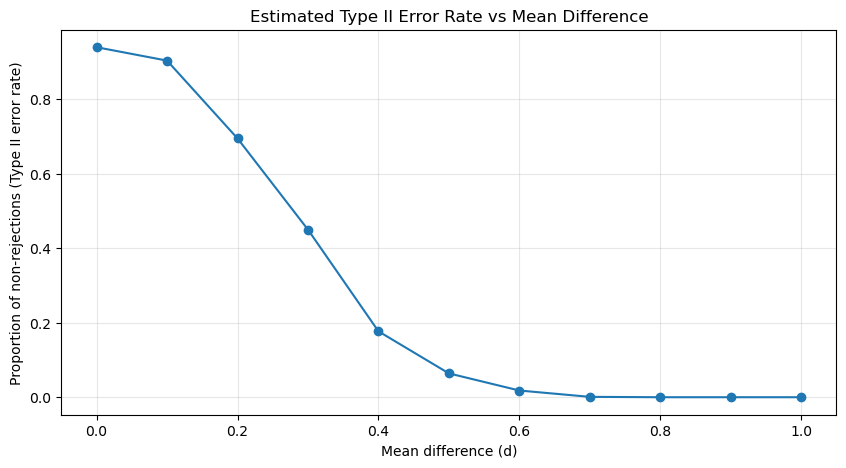

In [42]:
# Plot type II error rate vs d.
plt.figure(figsize=(10, 5))
plt.plot(d_values, type2_rates, marker='o')
plt.xlabel('Mean difference (d)')
plt.ylabel('Proportion of non-rejections (Type II error rate)')
plt.title('Estimated Type II Error Rate vs Mean Difference')
plt.grid(True, alpha=0.3)
plt.show()

### Explanation

- When d = 0, the null hypothesis is true (both means are the same). In that case, the proportion of *non-rejections* should be high (around 95%), because we only reject about 5% of the time by design (α = 0.05).

- As d increases, the two group means move further apart, so the test becomes more likely to detect a difference. That means the p-values get smaller more often, so we reject $H_0$ more frequently.

So the type II error rate decreases as the mean difference increases.

## Problem 4: Anova

Generate three independent samples (n=30) from normal distributions with means 0, 0.5, and 1 (sd=1). Then compare a one way ANOVA with three pairwise two sample t-tests.


In [43]:
#Imporing libraries

# Arrays.
import numpy as np

# Plotting.
import matplotlib.pyplot as plt

# Statistics.
import scipy.stats as stats

### Generating samples
I will generate three independent samples of size 30 from:
- Sample 1: Normal(mean=0, sd=1)
- Sample 2: Normal(mean=0.5, sd=1)
- Sample 3: Normal(mean=1, sd=1)

A random seed is set so results are reproducible.


In [44]:
# Reproducible randomness.
np.random.seed(42)

n = 30
sd = 1.0

sample_1 = np.random.normal(loc=0.0, scale=sd, size=n)
sample_2 = np.random.normal(loc=0.5, scale=sd, size=n)
sample_3 = np.random.normal(loc=1.0, scale=sd, size=n)

# Quick summary.
means = np.array([sample_1.mean(), sample_2.mean(), sample_3.mean()])
sds = np.array([sample_1.std(ddof=1), sample_2.std(ddof=1), sample_3.std(ddof=1)])

means, sds


(array([-0.1881469 ,  0.37883753,  1.01288477]),
 array([0.90000643, 0.9311022 , 0.99198304]))

### Visualising the samples
Histograms and a boxplot help us see how much overlap there is.


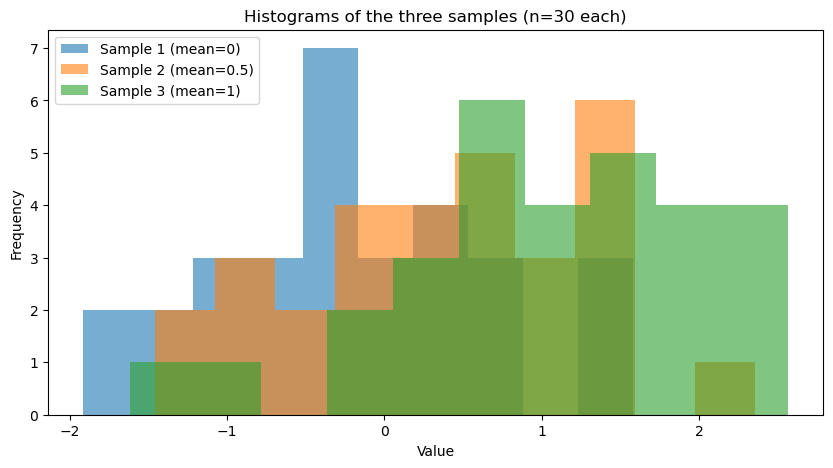

In [45]:
# Create histograms.
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(sample_1, bins=10, alpha=0.6, label="Sample 1 (mean=0)")
ax.hist(sample_2, bins=10, alpha=0.6, label="Sample 2 (mean=0.5)")
ax.hist(sample_3, bins=10, alpha=0.6, label="Sample 3 (mean=1)")

ax.set_title("Histograms of the three samples (n=30 each)")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()


C:\Users\owenc\AppData\Local\Temp\ipykernel_2464\3816296857.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([sample_1, sample_2, sample_3], labels=["Sample 1", "Sample 2", "Sample 3"])


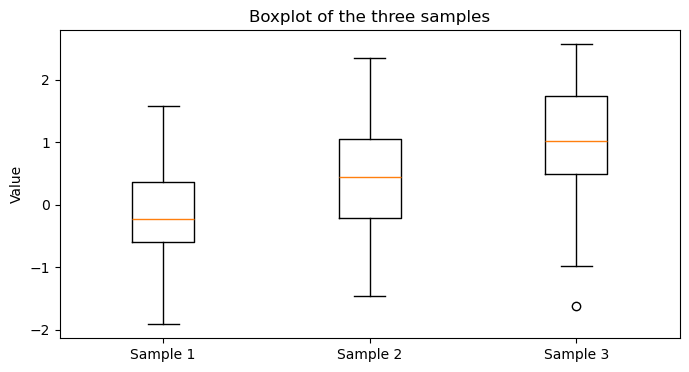

In [46]:
# Boxplot.
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot([sample_1, sample_2, sample_3], labels=["Sample 1", "Sample 2", "Sample 3"])
ax.set_title("Boxplot of the three samples")
ax.set_ylabel("Value")
plt.show()

### One way ANOVA

Null hypothesis: all three population means are equal.

Alternative: at least one mean differs.


In [47]:
# One-way ANOVA.
f_stat, p_anova = stats.f_oneway(sample_1, sample_2, sample_3)
f_stat, p_anova

(12.209525517972807, 2.120074814050707e-05)

In [48]:
# One-way ANOVA.
f_stat, p_anova = stats.f_oneway(sample_1, sample_2, sample_3)
f_stat, p_anova


(12.209525517972807, 2.120074814050707e-05)

### Two-sample t-tests
I run three independent two-sample t-tests:
- Sample 1 vs Sample 2
- Sample 1 vs Sample 3
- Sample 2 vs Sample 3

In [49]:
# Two-sample t-tests
pairs = [
    ("1 vs 2", sample_1, sample_2),
    ("1 vs 3", sample_1, sample_3),
    ("2 vs 3", sample_2, sample_3),
]

results = []
for name, a, b in pairs:
    t_stat, p_val = stats.ttest_ind(a, b, equal_var=True)
    results.append((name, t_stat, p_val))

results


[('1 vs 2', -2.398115152010245, 0.019717941865758048),
 ('1 vs 3', -4.911326340958337, 7.737964508099687e-06),
 ('2 vs 3', -2.5525907328394117, 0.013347246886682384)]

In [50]:
# Print conclusions at alpha = 0.05.
for name, t_stat, p_val in results:
    decision = "Reject H0" if p_val < alpha else "Fail to reject H0"
    print(f"{name}: t = {t_stat:.4f}, p = {p_val:.4g} -> {decision}")


1 vs 2: t = -2.3981, p = 0.01972 -> Reject H0
1 vs 3: t = -4.9113, p = 7.738e-06 -> Reject H0
2 vs 3: t = -2.5526, p = 0.01335 -> Reject H0


### Comparing the Conclusions
ANOVA tells us whether there is evidence that at least one mean differs.

The t-tests tell us which specific pairs show evidence of different means. However, doing multiple t-tests increases the chance of a false positive somewhere.


In [51]:
# Bonferroni-adjusted alpha for 3 comparisons.
alpha_bonf = alpha / 3
print(f"Bonferroni-adjusted alpha = {alpha_bonf:.4f}")

for name, t_stat, p_val in results:
    decision = "Reject H0" if p_val < alpha_bonf else "Fail to reject H0"
    print(f"{name}: p = {p_val:.4g} -> {decision} (Bonferroni)")


Bonferroni-adjusted alpha = 0.0167
1 vs 2: p = 0.01972 -> Fail to reject H0 (Bonferroni)
1 vs 3: p = 7.738e-06 -> Reject H0 (Bonferroni)
2 vs 3: p = 0.01335 -> Reject H0 (Bonferroni)


### Why ANOVA is preferred over running several t-tests

- It controls overall Type I errors: with several t-tests, the probability of making at least one false rejection increases as the number of tests grows.
- ANOVA provides one overall test for differences among multiple means. If significant, you can then use post hoc procedures designed for multiple comparisons (e.g., Tukey HSD) instead of unadjusted t-tests.
- ANOVA is the standard approach when comparing more than two group means.


# End